## 1. Data Reading using pandas

In [1]:
import pandas as pd

df = pd.read_csv('../data/raw.csv')

df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


## 2. Data Preprocessing

<Axes: xlabel='status', ylabel='statement'>

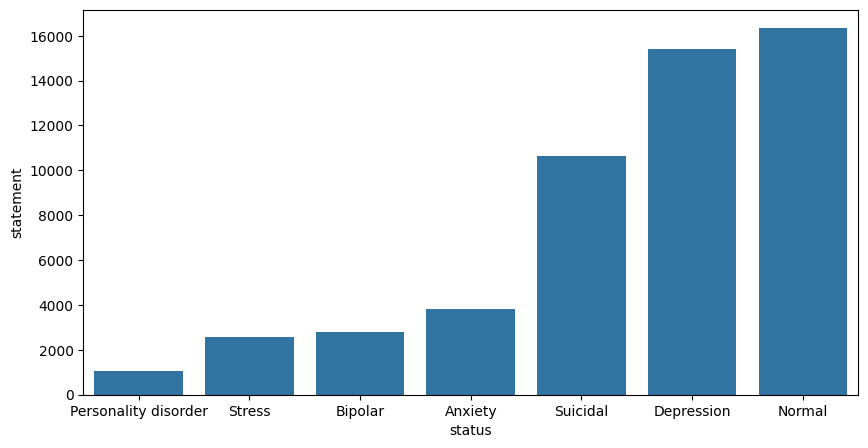

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

df.replace("", np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
data = df.groupby('status')['statement'].count().sort_values().reset_index()
plt.figure(figsize = (10,5))
sns.barplot(data=data,x='status',y='statement')

- Regex to remove unneeded symbol, punctuation, etc.

In [3]:
import re
from string import punctuation

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\[\]]*', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df['statement'] = df['statement'].apply(preprocess_text)

- Using stopwords to remove unneeded words

In [4]:
from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')

def remove_stopwords(text: str) -> str:
    return ' '.join([word for word in text.split() if word not in eng_stopwords])

df['statement'] = df['statement'].apply(remove_stopwords)

- WordNetLemmatizer **(Understands word by it's context according to its sentences)**

In [5]:
import spacy
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

def understand_text(text: str) -> str:
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return ' '.join(tokens)

df['statement'] = df['statement'].apply(understand_text)

- Dropping row for:
  - Empty statements
  - Whitespace statements
  - Duplicate statements

In [24]:
# Dropping empty statement
df = df[df['statement'] != '']

# Dropping whitespace statement
df = df[df['statement'].str.strip() != '']

# Dropping duplicate statement
df = df.drop_duplicates(subset='statement')

# Dropping statement with less than 3 words
df = df[df['statement'].apply(lambda x: len(x.split()) > 2)]

# Dropping statement with more than 100 words
df = df[df['statement'].apply(lambda x: len(x.split()) < 161)]

- Shape checking

In [25]:
df.shape

(41925, 3)

- Data Splitting (statements & labels)

In [26]:
train_statements = df['statement'].values
train_labels = df['status'].values

## 3. Encode the data (statements & labels)

- statements encoding

  1. Create a tokenizer: `tf.keras.preprocessing.text.Tokenizer(...)`

    - Takes only 10000 words that will be kept onto the vocabulary.
    - oov_token: "out of vocabulary" -> use to represent any word that is not part of tokenizer's vocabulary.
  2. Apply the sentences: `tokenizer.fit_on_texts(...)`
    - `fit_on_texts()`: **Counts word frequencies** in the given text and **creates an index** where each word is *assigned* an integer.
  3. Convert each sentence into a sequence of integers: `texts_to_sequences(...)`
      - Words that **are not in the top 10000** most frequent words are replaced by the index for the `<OOV>` token.

In [27]:
import tensorflow as tf

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token='<OOV>')

tokenizer.fit_on_texts(train_statements)

train_sequences = tokenizer.texts_to_sequences(train_statements)

- Getting max length of a token for padded sequences making

In [28]:
max_sequence_length = max(len(token) for token in train_sequences)

max_sequence_length

99

- Changing `train_sequences` into padded sequences

  Why do we need to pads the sequences?

  - Pads the sequences of integers is to ensure they all have the same length: `tf.keras.preprocessing.sequence.pad_sequences(...)`
  - `maxlen=500`: Specifies that each sequence will have a maximum length of 500. **If a sequence is shorter than 500 words, it will be padded with zeros to make its length 500.**
  - `padding='post'`: Specifies that the padding (zeros) **will be added to the end** of each sequence (after the text).

In [29]:
train_pad_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

train_pad_sequences

array([[ 552,   55,  829, ...,    0,    0,    0],
       [ 120, 1701,  399, ...,    0,    0,    0],
       [  68,  955,  402, ...,    0,    0,    0],
       ...,
       [ 777,   27,  292, ...,    0,    0,    0],
       [7341,   14, 1009, ...,    0,    0,    0],
       [  13,   12,   27, ...,    0,    0,    0]])

- One Hot Encoding

In [30]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_label_arrays = encoder.fit_transform(train_labels)

# One-Hot Encoding
train_label_arrays = tf.keras.utils.to_categorical(train_label_arrays)

train_label_arrays

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

- Shape checking

In [31]:
train_pad_sequences.shape, train_label_arrays.shape

((41925, 99), (41925, 7))

## 7. Data training with (80:10:10) format

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(train_pad_sequences, train_label_arrays, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## 8. Create the neural network

- Getting input_size for embedding layer input dimensions

In [33]:
input_size = np.max([np.max(X_train), np.max(y_train)]) + 1
input_size = int(input_size)

input_size

10000

In [81]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_size, output_dim=128),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(7, activation='softmax')
])

- Compile the model using:

    - Adam for learning-rate optimizer
    - Categorical Crossentropy for loss calculations

In [82]:
model.compile(  optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [83]:
early_stopping = tf.keras.callbacks.EarlyStopping(  monitor='val_loss', 
                                                    patience=3, 
                                                    restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.5, 
                                                    patience=1,)

In [86]:
history = model.fit(X_train,
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/10
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - accuracy: 0.8038 - loss: 0.6139 - val_accuracy: 0.7166 - val_loss: 0.8591 - learning_rate: 1.2500e-04
Epoch 2/10
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 83s 80ms/step - accuracy: 0.8256 - loss: 0.5491 - val_accuracy: 0.7135 - val_loss: 0.8698 - learning_rate: 1.2500e-04
Epoch 3/10
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 85s 81ms/step - accuracy: 0.8344 - loss: 0.5137 - val_accuracy: 0.7207 - val_loss: 0.8753 - learning_rate: 6.2500e-05
Epoch 4/10
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 87s 83ms/step - accuracy: 0.8462 - loss: 0.4880 - val_accuracy: 0.7228 - val_loss: 0.8791 - learning_rate: 3.1250e-05


In [87]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy with Neural Network: {accuracy}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7240 - loss: 0.8632
Test Accuracy with Neural Network: 0.7228714227676392


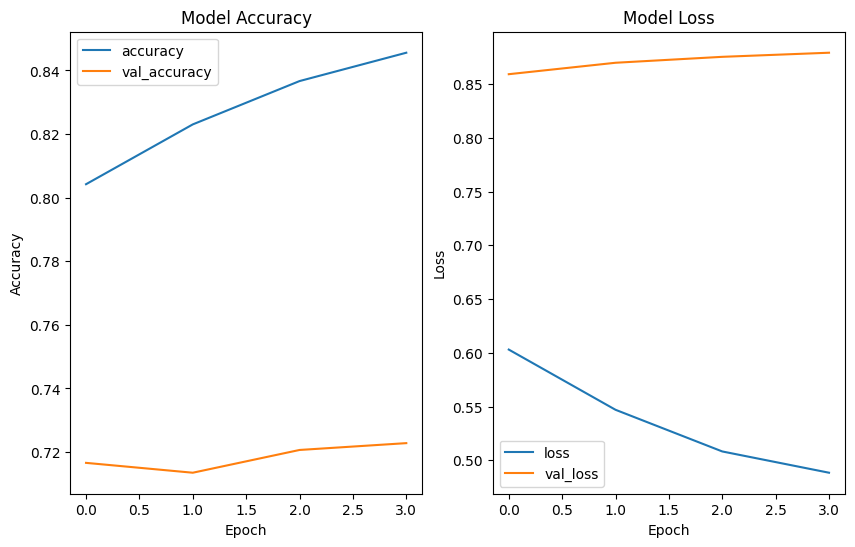

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [90]:
def predict_statement(statement: str) -> str:
    statement = preprocess_text(statement)
    statement = remove_stopwords(statement)
    statement = understand_text(statement)
    statement = tokenizer.texts_to_sequences([statement])
    statement = tf.keras.preprocessing.sequence.pad_sequences(statement, maxlen=max_sequence_length, padding='post', truncating='post')
    prediction = model.predict(statement)
    prediction = encoder.inverse_transform([np.argmax(prediction)])
    return prediction[0]

statement = "I know I should be proud of my accomplishments, but I still feel like I have failed."
prediction = predict_statement(statement)
print(f"Prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction: Depression


In [91]:
model.save('../model/keras/model.keras')
model.save('../model/model.h5')